# Analyzing the MSTIS simulation

Included in this notebook:

* Opening files for analysis
* Rates, fluxes, total crossing probabilities, and condition transition probabilities
* Per-ensemble properties such as path length distributions and interface crossing probabilities
* Move scheme analysis
* Replica exchange analysis
* Replica move history tree visualization
* Replaying the simulation
* MORE TO COME! Like free energy projections, path density plots, and more

In [1]:

%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

The optimum way to use storage depends on whether you're doing production or analysis. For analysis, you should open the file as an `AnalysisStorage` object. This makes the analysis much faster.

In [2]:
%%time
storage = paths.AnalysisStorage("ala_mstis_production.nc")

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



CPU times: user 12.6 s, sys: 1.83 s, total: 14.4 s
Wall time: 17.8 s


In [3]:
print("PathMovers:", len(storage.pathmovers))
print("Engines:", len(storage.engines))
print("Samples:", len(storage.samples))
print("Ensembles:", len(storage.ensembles))
print("SampleSets:", len(storage.samplesets))
print("Snapshots:", len(storage.snapshots))
print("Trajectories:", len(storage.trajectories))
print("Networks:", len(storage.networks))

PathMovers: 125
Engines: 3
Samples: 1332
Ensembles: 315
SampleSets: 1001
Snapshots: 42222
Trajectories: 800
Networks: 1


In [4]:
%%time
mstis = storage.networks[0]

CPU times: user 14 µs, sys: 1 µs, total: 15 µs
Wall time: 20 µs


In [5]:
%%time
for cv in storage.cvs:
    print(cv.name, cv._store_dict)

opA None
phi <openpathsampling.netcdfplus.chaindict.StoredDict object at 0x1333abad0>
psi <openpathsampling.netcdfplus.chaindict.StoredDict object at 0x13362bf90>
max opA <openpathsampling.netcdfplus.chaindict.StoredDict object at 0x13362b310>
opD None
opC None
opB None
max opB <openpathsampling.netcdfplus.chaindict.StoredDict object at 0x13373b350>
max opC <openpathsampling.netcdfplus.chaindict.StoredDict object at 0x133580e90>
max opD <openpathsampling.netcdfplus.chaindict.StoredDict object at 0x133739990>
CPU times: user 261 µs, sys: 63 µs, total: 324 µs
Wall time: 286 µs


## Reaction rates

TIS methods are especially good at determining reaction rates, and OPS makes it extremely easy to obtain the rate from a TIS network.

Note that, although you can get the rate directly, it is very important to look at other results of the sampling (illustrated in this notebook and in notebooks referred to herein) in order to check the validity of the rates you obtain.

By default, the built-in analysis calculates histograms the maximum value of some order parameter and the pathlength of every sampled ensemble. You can add other things to this list as well, but you must always specify histogram parameters for these two. The pathlength is in units of frames.

In [35]:
mstis.hist_args['max_lambda'] = { 'bin_width' : 20, 'bin_range' : (0.0, 90) }
mstis.hist_args['pathlength'] = { 'bin_width' : 30, 'bin_range' : (0, 100) }

In [36]:
%%time
mstis.rate_matrix(storage.steps, force=True)

/Users/matteo/.local/share/virtualenvs/quantum-folding-aHaLeqp8/lib/python3.11/site-packages/openpathsampling/numerics/wham.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  unweighting = cleaned_df.copy().applymap(
/Users/matteo/.local/share/virtualenvs/quantum-folding-aHaLeqp8/lib/python3.11/site-packages/openpathsampling/numerics/wham.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  unweighting = cleaned_df.copy().applymap(
/Users/matteo/.local/share/virtualenvs/quantum-folding-aHaLeqp8/lib/python3.11/site-packages/openpathsampling/numerics/wham.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  unweighting = cleaned_df.copy().applymap(
/Users/matteo/.local/share/virtualenvs/quantum-folding-aHaLeqp8/lib/python3.11/site-packages/openpathsampling/numerics/wham.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  unweightin

CPU times: user 769 ms, sys: 17.1 ms, total: 786 ms
Wall time: 859 ms


,A,B,C,D
A,NaN,0.17268804219636216 /ps,0.06490826644039598 /ps,0.011619381029453603 /ps
B,0.3212152488219509 /ps,NaN,0.0 /ps,0.0 /ps
C,0.0068843494735820404 /ps,0.0 /ps,NaN,0.10861973613873886 /ps
D,0.17763760375008752 /ps,0.12200384872945572 /ps,0.3445388688119829 /ps,NaN


In [59]:
3import pandas as pd
data = [i.split("\t") for i in ["k8	1/2025	6.26",
"k-8	1/132	3.53",
"k9	1/2425	6.44",
"k-9	1/158	3.71",
"k6c	1/36	2.23",
"k-6	1/(s × 328) = 1/1181	4.44",
"k7	1/136	3.56",
"k-7	1/4000	5.66",
"k10	1/(s × 2150) = 1/7740	6.32",
"k-10	1/104	3.29",
"k12	1/105	3.3",
"k-12	1/54	2.63"]]
pd.DataFrame(data, columns=["Foo", "br", "c"])

,Foo,br,c
0,k8,1/2025,6.26
1,k-8,1/132,3.53
2,k9,1/2425,6.44
3,k-9,1/158,3.71
4,k6c,1/36,2.23
5,k-6,1/(s × 328) = 1/1181,4.44
6,k7,1/136,3.56
7,k-7,1/(s × 1111) = 1/4000,5.66
8,k10,1/(s × 2150) = 1/7740,6.32
9,k-10,1/104,3.29


In [ ]:
k8	1/2025	6.26
k-8	1/132	3.53
k9	1/2425	6.44
k-9	1/158	3.71
k6c	1/36	2.23
k-6	1/(s × 328) = 1/1181	4.44
k7	1/136	3.56
k-7	1/(s × 1111) = 1/4000	5.66
k10	1/(s × 2150) = 1/7740	6.32
k-10	1/104	3.29
k12	1/105	3.3
k-12	1/54	2.63

The self-rates (the rate of returning the to initial state) are undefined, and return not-a-number.

The rate is calcuated according to the formula:

$$k_{AB} = \phi_{A,0} P(B|\lambda_m) \prod_{i=0}^{m-1} P(\lambda_{i+1} | \lambda_i)$$

where $\phi_{A,0}$ is the flux from state A through its innermost interface, $P(B|\lambda_m)$ is the conditional transition probability (the probability that a path which crosses the interface at $\lambda_m$ ends in state B), and $\prod_{i=0}^{m-1} P(\lambda_{i+1} | \lambda_i)$ is the total crossing probability. We can look at each of these terms individually.

### Total crossing probability

In [37]:
stateA = storage.volumes["A"]
stateB = storage.volumes["B"]
stateC = storage.volumes["C"]

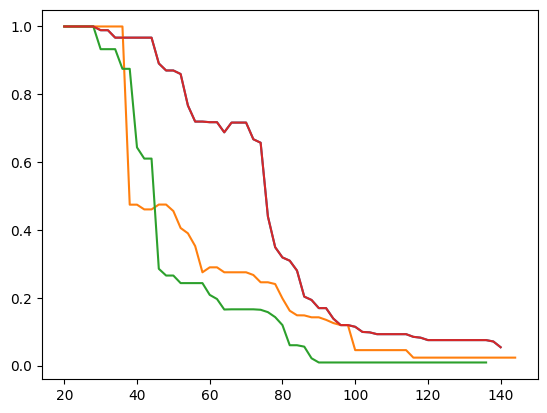

In [38]:
tcp_AB = mstis.transitions[(stateA, stateB)].tcp
tcp_AC = mstis.transitions[(stateA, stateC)].tcp
tcp_BC = mstis.transitions[(stateB, stateC)].tcp
tcp_BA = mstis.transitions[(stateB, stateA)].tcp
tcp_CA = mstis.transitions[(stateC, stateA)].tcp
tcp_CB = mstis.transitions[(stateC, stateB)].tcp

plt.plot(tcp_AB.x, tcp_AB)
plt.plot(tcp_CA.x, tcp_CA)
plt.plot(tcp_BC.x, tcp_BC)
plt.plot(tcp_AC.x, tcp_AC) # same as tcp_AB in MSTIS

We normally look at these on a log scale:

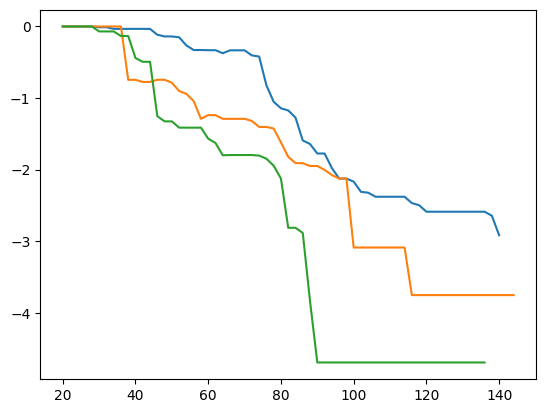

In [39]:
plt.plot(tcp_AB.x, np.log(tcp_AB))
plt.plot(tcp_CA.x, np.log(tcp_CA))
plt.plot(tcp_BC.x, np.log(tcp_BC))

### Flux

Here we also calculate the flux contribution to each transition. The flux is calculated based on

In [68]:
import pandas as pd
flux_matrix = pd.DataFrame(columns=mstis.states, index=mstis.states)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    flux_matrix.at[state_pair[0], state_pair[1]] = transition._flux

flux_matrix

AttributeError: 'CVDefinedVolume' object has no attribute '_reversed'

### Conditional transition probability

In [69]:
outer_ctp_matrix = pd.DataFrame(columns=mstis.states, index=mstis.states)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    outer_ctp_matrix.at[state_pair[0], state_pair[1]] = transition.ctp[transition.ensembles[-1]]

outer_ctp_matrix

AttributeError: 'CVDefinedVolume' object has no attribute '_reversed'

## Path ensemble properties

In [42]:
hists_A = mstis.transitions[(stateA, stateB)].histograms
hists_B = mstis.transitions[(stateB, stateC)].histograms
hists_C = mstis.transitions[(stateC, stateB)].histograms

### Interface crossing probabilities

We obtain the total crossing probability, shown above, by combining the individual crossing probabilities of

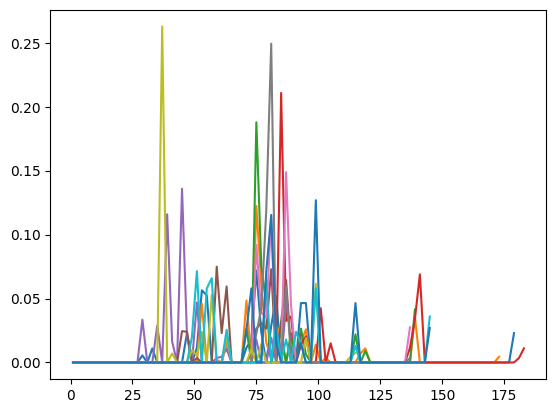

In [43]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        normalized = hist['max_lambda'][ens].normalized()
        plt.plot(normalized.x, normalized)

In [44]:
# add visualization of the sum

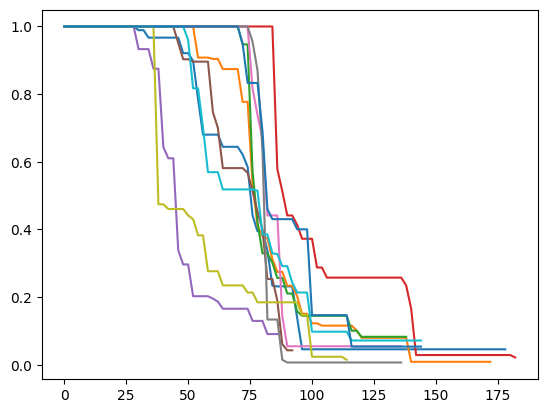

In [45]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        reverse_cumulative = hist['max_lambda'][ens].reverse_cumulative()
        plt.plot(reverse_cumulative.x, reverse_cumulative)

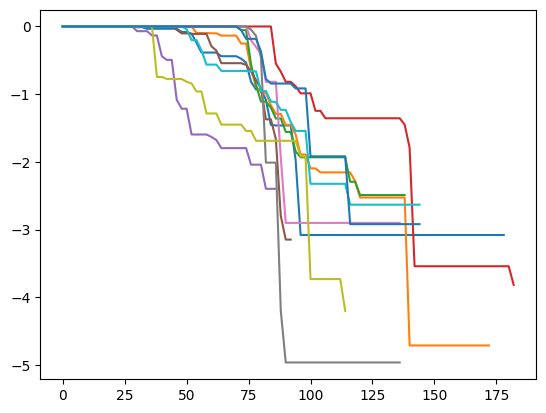

In [46]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        reverse_cumulative = hist['max_lambda'][ens].reverse_cumulative()
        plt.plot(reverse_cumulative.x, np.log(reverse_cumulative))

### Path length histograms

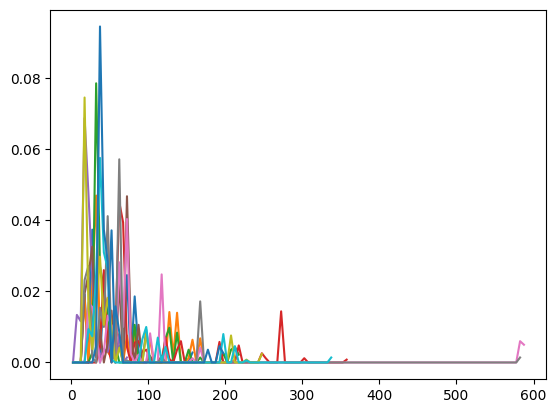

In [47]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['pathlength']:
        normalized = hist['pathlength'][ens].normalized()
        plt.plot(normalized.x, normalized)

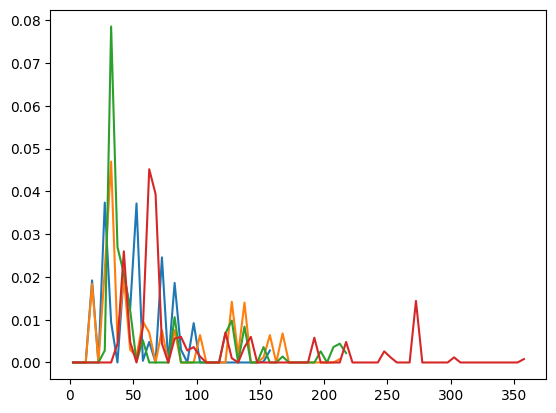

In [48]:
for ens in hists_A['pathlength']:
    normalized = hists_A['pathlength'][ens].normalized()
    plt.plot(normalized.x, normalized)

## Sampling properties

The properties we illustrated above were properties of the path ensembles. If your path ensembles are sufficiently well-sampled, these will never depend on how you sample them.

But to figure out whether you've done a good job of sampling, you often want to look at properties related to the sampling process. OPS also makes these very easy.

### Move scheme analysis

In [60]:
scheme = storage.schemes[0]

In [61]:
scheme.move_summary(storage.steps)

  0%|          | 0/1001 [00:00<?, ?it/s]

repex ran 23.900% (expected 23.10%) of the cycles with acceptance 119/239 (49.79%)
shooting ran 45.000% (expected 46.20%) of the cycles with acceptance 297/450 (66.00%)
pathreversal ran 25.300% (expected 24.75%) of the cycles with acceptance 105/253 (41.50%)
minus ran 2.700% (expected 2.64%) of the cycles with acceptance 19/27 (70.37%)
ms_outer_shooting ran 3.100% (expected 3.30%) of the cycles with acceptance 20/31 (64.52%)


In [62]:
scheme.move_summary(storage.steps, 'shooting')

OneWayShootingMover Out A 0 ran 3.400% (expected 3.30%) of the cycles with acceptance 25/34 (73.53%)
OneWayShootingMover Out A 1 ran 3.400% (expected 3.30%) of the cycles with acceptance 23/34 (67.65%)
OneWayShootingMover Out A 2 ran 2.500% (expected 3.30%) of the cycles with acceptance 20/25 (80.00%)
OneWayShootingMover Out A 3 ran 4.900% (expected 3.30%) of the cycles with acceptance 25/49 (51.02%)
OneWayShootingMover Out B 0 ran 2.200% (expected 3.30%) of the cycles with acceptance 17/22 (77.27%)
OneWayShootingMover Out B 1 ran 3.800% (expected 3.30%) of the cycles with acceptance 29/38 (76.32%)
OneWayShootingMover Out B 2 ran 3.900% (expected 3.30%) of the cycles with acceptance 22/39 (56.41%)
OneWayShootingMover Out B 3 ran 2.300% (expected 3.30%) of the cycles with acceptance 11/23 (47.83%)
OneWayShootingMover Out C 0 ran 3.100% (expected 3.30%) of the cycles with acceptance 21/31 (67.74%)
OneWayShootingMover Out C 1 ran 3.400% (expected 3.30%) of the cycles with acceptance 24/34

/Users/matteo/.local/share/virtualenvs/quantum-folding-aHaLeqp8/lib/python3.11/site-packages/openpathsampling/high_level/move_scheme.py:890: UserWarning: Move acceptance already calculated. The steps parameter will be ignored.
  warnings.warn("Move acceptance already calculated. "


In [63]:
scheme.move_summary(storage.steps, 'minus')

Minus ran 0.800% (expected 0.66%) of the cycles with acceptance 4/8 (50.00%)
Minus ran 0.900% (expected 0.66%) of the cycles with acceptance 9/9 (100.00%)
Minus ran 0.400% (expected 0.66%) of the cycles with acceptance 2/4 (50.00%)
Minus ran 0.600% (expected 0.66%) of the cycles with acceptance 4/6 (66.67%)


/Users/matteo/.local/share/virtualenvs/quantum-folding-aHaLeqp8/lib/python3.11/site-packages/openpathsampling/high_level/move_scheme.py:890: UserWarning: Move acceptance already calculated. The steps parameter will be ignored.
  warnings.warn("Move acceptance already calculated. "


In [64]:
scheme.move_summary(storage.steps, 'repex')

ReplicaExchange ran 1.000% (expected 1.65%) of the cycles with acceptance 10/10 (100.00%)
ReplicaExchange ran 2.100% (expected 1.65%) of the cycles with acceptance 20/21 (95.24%)
ReplicaExchange ran 1.600% (expected 1.65%) of the cycles with acceptance 2/16 (12.50%)
ReplicaExchange ran 1.900% (expected 1.65%) of the cycles with acceptance 10/19 (52.63%)
ReplicaExchange ran 2.500% (expected 1.65%) of the cycles with acceptance 12/25 (48.00%)
ReplicaExchange ran 2.400% (expected 1.65%) of the cycles with acceptance 21/24 (87.50%)
ReplicaExchange ran 1.600% (expected 1.65%) of the cycles with acceptance 6/16 (37.50%)
ReplicaExchange ran 1.400% (expected 1.65%) of the cycles with acceptance 7/14 (50.00%)
ReplicaExchange ran 1.300% (expected 1.65%) of the cycles with acceptance 3/13 (23.08%)
ReplicaExchange ran 1.200% (expected 1.65%) of the cycles with acceptance 9/12 (75.00%)
ReplicaExchange ran 1.800% (expected 1.65%) of the cycles with acceptance 13/18 (72.22%)
ReplicaExchange ran 1.800

/Users/matteo/.local/share/virtualenvs/quantum-folding-aHaLeqp8/lib/python3.11/site-packages/openpathsampling/high_level/move_scheme.py:890: UserWarning: Move acceptance already calculated. The steps parameter will be ignored.
  warnings.warn("Move acceptance already calculated. "


In [65]:
scheme.move_summary(storage.steps, 'pathreversal')

PathReversal ran 1.500% (expected 1.65%) of the cycles with acceptance 7/15 (46.67%)
PathReversal ran 2.400% (expected 1.65%) of the cycles with acceptance 8/24 (33.33%)
PathReversal ran 1.500% (expected 1.65%) of the cycles with acceptance 5/15 (33.33%)
PathReversal ran 2.500% (expected 1.65%) of the cycles with acceptance 11/25 (44.00%)
PathReversal ran 1.400% (expected 1.65%) of the cycles with acceptance 13/14 (92.86%)
PathReversal ran 1.400% (expected 1.65%) of the cycles with acceptance 2/14 (14.29%)
PathReversal ran 2.200% (expected 1.65%) of the cycles with acceptance 3/22 (13.64%)
PathReversal ran 2.200% (expected 1.65%) of the cycles with acceptance 1/22 (4.55%)
PathReversal ran 1.400% (expected 1.65%) of the cycles with acceptance 12/14 (85.71%)
PathReversal ran 1.600% (expected 1.65%) of the cycles with acceptance 7/16 (43.75%)
PathReversal ran 1.500% (expected 1.65%) of the cycles with acceptance 1/15 (6.67%)
PathReversal ran 2.200% (expected 1.65%) of the cycles with acce

/Users/matteo/.local/share/virtualenvs/quantum-folding-aHaLeqp8/lib/python3.11/site-packages/openpathsampling/high_level/move_scheme.py:890: UserWarning: Move acceptance already calculated. The steps parameter will be ignored.
  warnings.warn("Move acceptance already calculated. "


### Replica exchange sampling

See the notebook `repex_networks.ipynb` for more details on tools to study the convergence of replica exchange. However, a few simple examples are shown here. All of these are analyzed with a separate object, `ReplicaNetwork`.

In [66]:
repx_net = paths.ReplicaNetwork(scheme, storage.steps)

#### Replica exchange mixing matrix

In [27]:
repx_net.mixing_matrix()

,15,14,17,4,0,11,5,1,12,6,2,13,7,3,18,10,9,8,16
15,0.000000,0.000000,0.000000,0.023428,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14,0.000000,0.000000,0.000000,0.000000,0.023819,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
17,0.000000,0.000000,0.000000,0.000000,0.000000,0.030457,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.023428,0.000000,0.000000,0.000000,0.000000,0.000000,0.012105,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,0.000000,0.023819,0.000000,0.000000,0.000000,0.000000,0.000000,0.021866,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11,0.000000,0.000000,0.030457,0.000000,0.000000,0.000000,0.000000,0.000000,0.006638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.012105,0.000000,0.000000,0.000000,0.000000,0.000000,0.045685,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.021866,0.000000,0.000000,0.000000,0.000000,0.000000,0.030847,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12,0.000000,0.000000,0.000000,0.000000,0.000000,0.006638,0.000000,0.000000,0.000000,0.000000,0.000000,0.030457,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045685,0.000000,0.000000,0.000000,0.000000,0.000000,0.046076,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Replica exchange graph

The mixing matrix tells a story of how well various interfaces are connected to other interfaces. The replica exchange graph is essentially a visualization of the mixing matrix (actually, of the transition matrix -- the mixing matrix is a symmetrized version of the transition matrix).

Note: We're still developing better layout tools to visualize these.

/home/dswenso1/miniconda2/envs/ops_py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


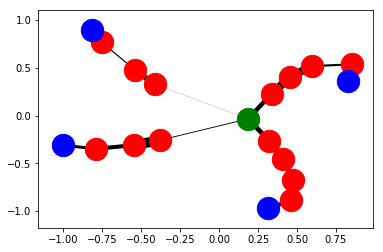

In [28]:
repxG = paths.ReplicaNetworkGraph(repx_net)
repxG.draw('spring')

#### Replica exchange flow

Replica flow is defined as ***TODO***

Flow is designed for calculations where the replica exchange graph is linear, which ours clearly is not. However, we can define the flow over a subset of the interfaces.

### Replica move history tree

In [29]:
import openpathsampling.visualize as vis
#reload(vis)
from IPython.display import SVG

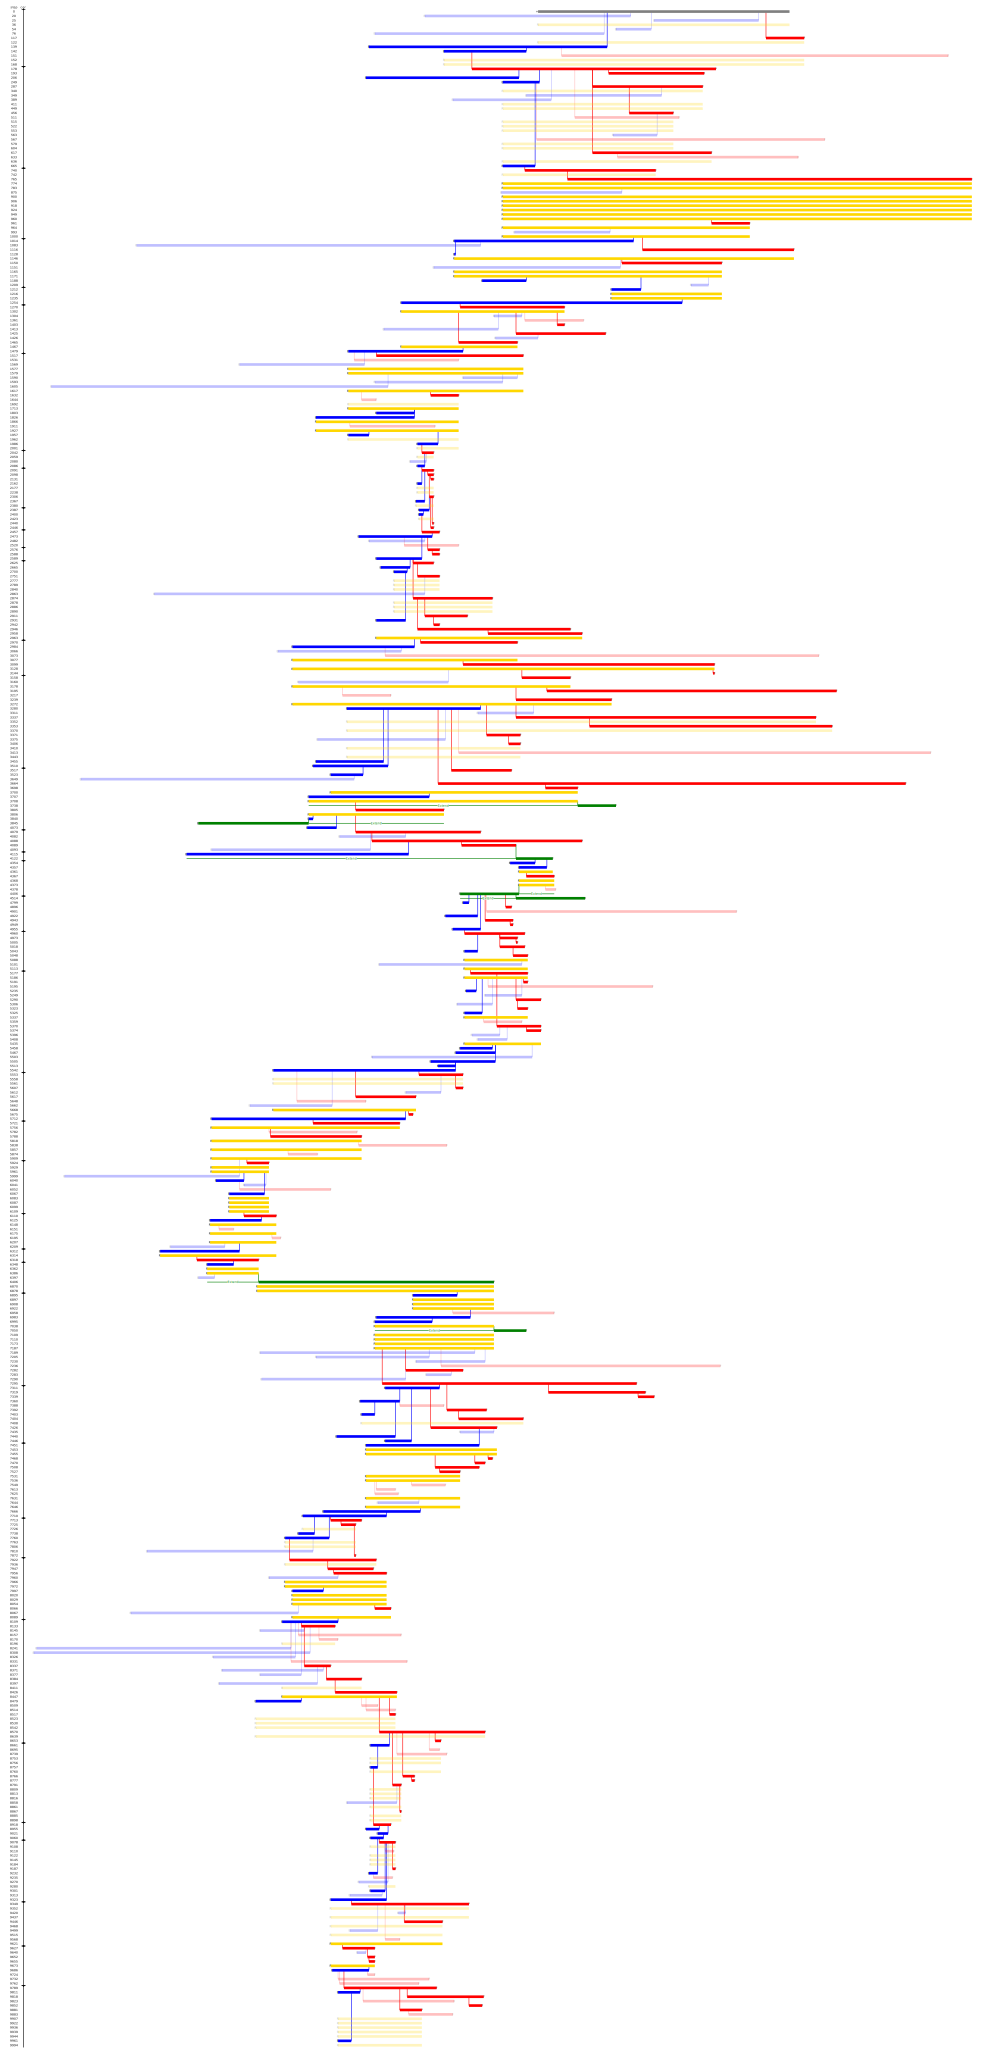

In [30]:
tree = vis.PathTree(
    [step for step in storage.steps if not isinstance(step.change, paths.EmptyMoveChange)],
    vis.ReplicaEvolution(replica=3, accepted=False)
)
tree.options.css['width'] = 'inherit'

SVG(tree.svg())

In [32]:
decorrelated = tree.generator.decorrelated
print ("We have " + str(len(decorrelated)) + " decorrelated trajectories.")

We have 40 decorrelated trajectories.


### Visualizing trajectories

## Histogramming data (TODO)

In [11]:
storage.close()
